<a href="https://colab.research.google.com/github/Ruby-L-i-n/CSDS234_FinalProject/blob/main/Files%20for%20Collaborative%20Filtering%20Recommendation%20Model/Collaborative_Filtering_MPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imported APIs
import numpy as np
import pandas as pd
import heapq
import random
import json
import matplotlib.pyplot as pyplot
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [ ]:
#mount to drive for datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training Data

## Pre-Processing and Formatting JSON Files

In [ ]:
#Here we are only using playlists from the first file of playlists because of hardware limitations
np.random.seed(seed = 19) #a random seed to ensure calculation is the same across methods. if you want to generate a different set of random numbers, enter a new seed

# The variables below are required for random selection of playlists
# (each JSON file stores 1000 playlists so if you wanted 2500 playlists from 3000 you could use these variables)
numbers = np.arange(0,1000,1) #a range of numbers from 1 to 1000
sample = np.random.choice(numbers, size=1000, replace=False) #an array storing the pids of the 800 random playlists

In [ ]:
# Loading the file from our drive
with open("/content/drive/Shareddrives/CSDS 234 Final Project/spotify_million_playlist_dataset/data/mpd.slice.0-999.json") as f:
    data = json.load(f)

# Creating our all-inclusive dataframe (df)

flattened_playlists = []
for playlist in data['playlists']:
    playlist_info = {
        'pid': playlist['pid'],
        'name': playlist.get('name', None),
        'collaborative': playlist['collaborative'],
        'modified_at': playlist['modified_at'],
        'num_tracks': playlist['num_tracks'],
        'num_albums': playlist['num_albums'],
        'num_followers': playlist['num_followers']
    }

    for track in playlist['tracks']:
        track_info = {
            'playlist_pid': playlist['pid'],
            'track_pos': track['pos'],
            'track_name': track['track_name'],
            'track_uri': track['track_uri'],
            'artist_name': track['artist_name'],
            'artist_uri': track['artist_uri'],
            'album_name': track['album_name'],
            'album_uri': track['album_uri'],
            'duration_ms': track['duration_ms']
        }
        flattened_playlists.append({**playlist_info, **track_info})

# Create a Pandas DataFrame for our schema
df = pd.DataFrame(flattened_playlists)

#View the first 10 tuples of our schema with 1000 playlists
df.head(10)

,pid,name,collaborative,modified_at,num_tracks,num_albums,num_followers,playlist_pid,track_pos,track_name,track_uri,artist_name,artist_uri,album_name,album_uri,duration_ms
0,0,Throwbacks,false,1493424000,52,47,1,0,0,Lose Control (feat. Ciara & Fat Man Scoop),spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,0,Throwbacks,false,1493424000,52,47,1,0,1,Toxic,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
2,0,Throwbacks,false,1493424000,52,47,1,0,2,Crazy In Love,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933
3,0,Throwbacks,false,1493424000,52,47,1,0,3,Rock Your Body,spotify:track:1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266
4,0,Throwbacks,false,1493424000,52,47,1,0,4,It Wasn't Me,spotify:track:1lzr43nnXAijIGYnCT8M8H,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600
5,0,Throwbacks,false,1493424000,52,47,1,0,5,Yeah!,spotify:track:0XUfyU2QviPAs6bxSpXYG4,Usher,spotify:artist:23zg3TcAtWQy7J6upgbUnj,Confessions,spotify:album:0vO0b1AvY49CPQyVisJLj0,250373
6,0,Throwbacks,false,1493424000,52,47,1,0,6,My Boo,spotify:track:68vgtRHr7iZHpzGpon6Jlo,Usher,spotify:artist:23zg3TcAtWQy7J6upgbUnj,Confessions,spotify:album:1RM6MGv6bcl6NrAG8PGoZk,223440
7,0,Throwbacks,false,1493424000,52,47,1,0,7,Buttons,spotify:track:3BxWKCI06eQ5Od8TY2JBeA,The Pussycat Dolls,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,PCD,spotify:album:5x8e8UcCeOgrOzSnDGuPye,225560
8,0,Throwbacks,false,1493424000,52,47,1,0,8,Say My Name,spotify:track:7H6ev70Weq6DdpZyyTmUXk,Destiny's Child,spotify:artist:1Y8cdNmUJH7yBTd9yOvr5i,The Writing's On The Wall,spotify:album:283NWqNsCA9GwVHrJk59CG,271333
9,0,Throwbacks,false,1493424000,52,47,1,0,9,Hey Ya! - Radio Mix / Club Mix,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,OutKast,spotify:artist:1G9G7WwrXka3Z1r7aIDjI7,Speakerboxxx/The Love Below,spotify:album:1UsmQ3bpJTyK6ygoOOjG1r,235213


In [ ]:
# Originally we only had a portion of the 1000 playlists randomly selected so this command could be used if we wanted to randomly select for
# increasing our data frame size

#Clean the data by selecting the random playlists

clean_df = df.loc[df["pid"].isin(sample)]
# del(df, numbers) # Release unused memory

# clean_df: the all-inclusive dataframe with all columns provided by spotify for 1000 playlists
clean_df.head()

,pid,name,collaborative,modified_at,num_tracks,num_albums,num_followers,playlist_pid,track_pos,track_name,track_uri,artist_name,artist_uri,album_name,album_uri,duration_ms
0,0,Throwbacks,false,1493424000,52,47,1,0,0,Lose Control (feat. Ciara & Fat Man Scoop),spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,0,Throwbacks,false,1493424000,52,47,1,0,1,Toxic,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
2,0,Throwbacks,false,1493424000,52,47,1,0,2,Crazy In Love,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933
3,0,Throwbacks,false,1493424000,52,47,1,0,3,Rock Your Body,spotify:track:1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266
4,0,Throwbacks,false,1493424000,52,47,1,0,4,It Wasn't Me,spotify:track:1lzr43nnXAijIGYnCT8M8H,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600


Before we start it is useful to gain some insights on the data we are working with. This will give us a better idea of what we need to clean and analyze.

In [ ]:
print("Total Number of Songs: ", len(set(clean_df["track_name"])))
print("Total Number of Playlists: ", len(set(clean_df["pid"])))
print("Average Number of Songs in a Playlist: ", (len(set(clean_df["track_name"])))/ len(set(clean_df["pid"])))

Total Number of Songs:  30049
Total Number of Playlists:  1000
Average Number of Songs in a Playlist:  30.049


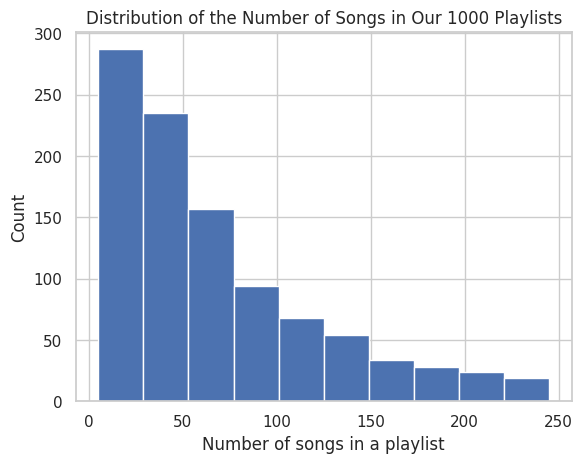

In [ ]:
pyplot.hist(clean_df['pid'].value_counts())
pyplot.title("Distribution of the Number of Songs in Our 1000 Playlists")
pyplot.ylabel("Count")
pyplot.xlabel("Number of songs in a playlist")
pyplot.show()

Text(0.5, 0, 'Total songs across playlists')

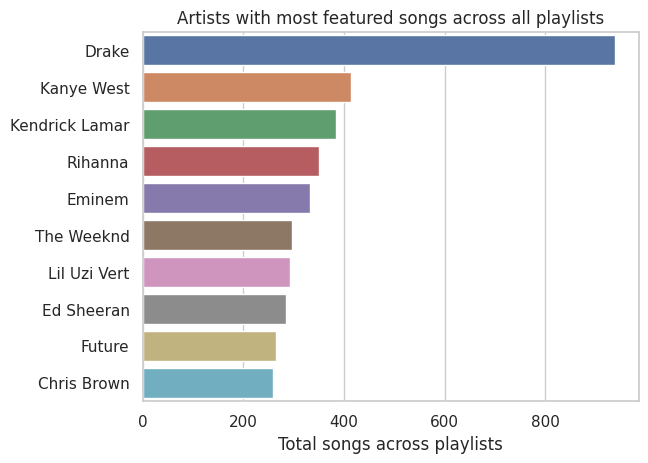

In [ ]:
# Checking which artists are featured most across all playlists
values = list(clean_df['artist_name'].value_counts())
names = clean_df['artist_name'].value_counts().index.tolist()

ax = sns.barplot(y=names[0:10], x=values[0:10])
ax.set_title('Artists with most featured songs across all playlists')
ax.set_xlabel('Total songs across playlists')

Here we see that Drake shows up in many of the playlists. While he is a really popular artist, this may indicate that our playlist recommendation model is better for those who like Drake. To address this issue we could process more playlists, but because of hardware limitations this is the training data set we are working with.

# Test Data

## Cleaning and Preprocessing

In [ ]:
#Randomly select a different JSON file with new playlist data to avoid selecting playlists from our training playlists

file_name_list = ['1000-1999', '2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999', '8000-8999', '9000-9999']
np.random.seed(seed=18) # This seed yield '4000-4999'
selected_file = np.random.choice(file_name_list)

with open("/content/drive/Shareddrives/CSDS 234 Final Project/spotify_million_playlist_dataset/data/mpd.slice."+ selected_file + ".json") as g:
    data = json.load(g)

    test_playlists = []
for playlist in data['playlists']:
    playlist_info = {
        'pid': playlist['pid'],
        'name': playlist.get('name', None),
        'collaborative': playlist['collaborative'],
        'modified_at': playlist['modified_at'],
        'num_tracks': playlist['num_tracks'],
        'num_albums': playlist['num_albums'],
        'num_followers': playlist['num_followers']
    }

    for track in playlist['tracks']:
        track_info = {
            #'playlist_pid': playlist['pid'], # is this a redudant variable?
            'track_pos': track['pos'],
            'track_name': track['track_name'],
            'track_uri': track['track_uri'],
            'artist_name': track['artist_name'],
            'artist_uri': track['artist_uri'],
            'album_name': track['album_name'],
            'album_uri': track['album_uri'],
            'duration_ms': track['duration_ms']
        }
        test_playlists.append({**playlist_info, **track_info})

# Create a Pandas DataFrame to store the test playlists
test1000_df = pd.DataFrame(test_playlists)
test1000_df.head(10)

,pid,name,collaborative,modified_at,num_tracks,num_albums,num_followers,track_pos,track_name,track_uri,artist_name,artist_uri,album_name,album_uri,duration_ms
0,4000,skate,true,1432252800,70,62,1,0,Circles,spotify:track:53yXbISmPFewWiFP2kgal8,Ty Segall,spotify:artist:58XGUNsRNu3cVOIOYk5chx,Mr. Face,spotify:album:5bXUYhd6yvmry49a8WpEqS,186176
1,4000,skate,true,1432252800,70,62,1,1,Ramble Tamble,spotify:track:47atuTch0AN7NvP9vp42a5,Creedence Clearwater Revival,spotify:artist:3IYUhFvPQItj6xySrBmZkd,Cosmo's Factory,spotify:album:4GLxEXWI3JiRKp6H7bfTIK,431226
2,4000,skate,true,1432252800,70,62,1,2,Brendan 1,spotify:track:7uzeJ1HasqTqqB2anNRFCs,Fugazi,spotify:artist:62sC6lUEWRjbFqXpMmOk4G,Repeater,spotify:album:3ZnF1cPxlqB48RyLiecDnv,152493
3,4000,skate,true,1432252800,70,62,1,3,Death of a Ladies' Man,spotify:track:5wrylUGwZugelovhryPYg2,Leonard Cohen,spotify:artist:5l8VQNuIg0turYE1VtM9zV,Death Of A Ladies' Man,spotify:album:0qghwsBOHAhmIukaW08IOT,564133
4,4000,skate,true,1432252800,70,62,1,4,After Laughter (Comes Tears),spotify:track:2bsAzwSesOofKlc8ip4MB7,Wendy Rene,spotify:artist:4ba7uNtpOq0us2C5Nx19zN,After Laughter Comes Tears: Complete Stax & Vo...,spotify:album:6lSJwPx7Sqdl7nGLHb3mkG,182893
5,4000,skate,true,1432252800,70,62,1,5,"How You Doin, Here We Go",spotify:track:3OWgczPOsu1xCWV5ClpV8Q,Ray Barbee Meets the Mattson 2,spotify:artist:6980BgFWNc5h3wbuhA6QTm,Ray Barbee Meet the Mattson 2,spotify:album:3RxFFFMvhjB87uLFSXzdl2,73600
6,4000,skate,true,1432252800,70,62,1,6,"Please, Please, Please - Live At The Apollo Th...",spotify:track:0HOqGdqxLZN68sdm06LDiV,James Brown & The Famous Flames,spotify:artist:32r72WOqqRO1DtSznId7Lr,'Live' At The Apollo Vol. II,spotify:album:7um5ZTFpHJQCbBdOdLbsCg,161466
7,4000,skate,true,1432252800,70,62,1,7,Wild Witch,spotify:track:5SHcOU4noUpL9OU3rnWxXl,Restavrant,spotify:artist:64Xip1q4drLaPRLqHXlzBU,"Yeah, I Carve Cheetahs",spotify:album:2CYymhzoMGZIYUrFXh0WBO,210430
8,4000,skate,true,1432252800,70,62,1,8,Gut Feeling,spotify:track:4fNbrazMYC1CbalcQ8YFGC,DEVO,spotify:artist:0UKfenbZb15sqhfPC6zbt3,The Life Aquatic With Steve Zissou,spotify:album:05mpXOy7NNlc3oGqNathD6,247160
9,4000,skate,true,1432252800,70,62,1,9,Good Morning Judge,spotify:track:0wLFcJ5jPNnpGwSdZ0JSG2,Furry Lewis,spotify:artist:66SiMdpsWXE23qqX0JaWg9,Good Morning Judge,spotify:album:4SejT5bBFYH6qC9ikemWl2,331333


In [ ]:
"""
We chose playlists (pids) with greater than 100 songs so that our model has at least 30 songs to work with if we
split 70% of the playlist into training and the other 30% into testing, we'd still have about our average playlist size
of 70 songs for our model to provide 30 recommendations for.
"""
# Filter playlists with between 100 and 200 tracks
large_test_pl = test1000_df[(test1000_df['num_tracks'] >= 90) & (test1000_df['num_tracks'] <= 200)]

# Randomly select 25 unique playlist pids
selected_playlist_pids = large_test_pl['pid'].sample(n=26, random_state=18).tolist()

# Filter the DataFrame to include only rows corresponding to the selected playlist pids
test_playlists = large_test_pl[large_test_pl['pid'].isin(selected_playlist_pids)]

# Display the first 10 tuples selected playlists
print(test_playlists.head(10))

# Display the pids of the selected playlists
print(test_playlists['pid'].unique())


      pid  name collaborative  modified_at  num_tracks  num_albums  num_followers  track_pos                      track_name                             track_uri           artist_name                             artist_uri                         album_name                             album_uri  duration_ms
101  4003  HOLA         false   1493424000         104          89              2          0  La Botella (Pasame La Botella)  spotify:track:48RhiOqPE7d817wb2OzlNN      Reggaeton Latino  spotify:artist:3sG7WHWEWaSVehXJRj7t4n                Reggaeton Best Hits  spotify:album:0pH52976tC7WkVa5wCz8Lk       182946
102  4003  HOLA         false   1493424000         104          89              2          1   Hasta el Amanecer - The Remix  spotify:track:4bisT9khxJYFKaoG8pxq5h             Nicky Jam  spotify:artist:1SupJlEpv7RS2tPNRaHViT                              Fénix  spotify:album:2dBgWXp41imu2zBNv9oFxZ       188466
103  4003  HOLA         false   1493424000         104          89    

## Splitting the Test Data

In [ ]:
"""
This is a function to break down a data frame of all playlists into separate dfs for a single playlist

Input: A large dataframe with several playlists
Output: A dictionary indexed by pid for each single playlist dataframe
"""
def store_single(df):
  playlists_dict = {}
  for pid in df['pid'].unique():
    playlist = df[df['pid'] == pid]
    playlists_dict[pid] = playlist.copy()  # Store each playlist in the dictionary

  return playlists_dict

# Splitting playlists into dataframes for each playlist
playlist_catalog = store_single(test_playlists)

print(playlist_catalog[4003])
print(playlist_catalog.keys())



      pid  name collaborative  modified_at  num_tracks  num_albums  num_followers  track_pos                      track_name                             track_uri           artist_name                             artist_uri           album_name                             album_uri  duration_ms
101  4003  HOLA         false   1493424000         104          89              2          0  La Botella (Pasame La Botella)  spotify:track:48RhiOqPE7d817wb2OzlNN      Reggaeton Latino  spotify:artist:3sG7WHWEWaSVehXJRj7t4n  Reggaeton Best Hits  spotify:album:0pH52976tC7WkVa5wCz8Lk       182946
102  4003  HOLA         false   1493424000         104          89              2          1   Hasta el Amanecer - The Remix  spotify:track:4bisT9khxJYFKaoG8pxq5h             Nicky Jam  spotify:artist:1SupJlEpv7RS2tPNRaHViT                Fénix  spotify:album:2dBgWXp41imu2zBNv9oFxZ       188466
103  4003  HOLA         false   1493424000         104          89              2          2              Andas 

In [ ]:
"""
Here we need to split our test playlists 0.7:0.3 training to test data.
We will need to select 30% of the playlist and store it for cross checking recommendations later.

If we are recommending for many playlists at once, we want to interate through each playlist df in the catalog
and split them into training and test data. We will use an imported function to make this easier/ more efficient.


Input: A dictionary of playlists with tracks in dataframes
Output: Dictionaries for the training and test dataframes
"""

def split_group(playlist_catalog):
  train_playlists_dict = {}
  test_playlists_dict = {}

  # Assuming playlist_catalog is a dictionary containing playlists
  for key in playlist_catalog:
    playlist = playlist_catalog[key]  # Get the playlist dataframe for the current key

    # Splitting the current playlist into 70% train and 30% test
    train_playlist, test_playlist = train_test_split(playlist, test_size=0.3)

    # Storing the split playlists in separate dictionaries
    train_playlists_dict[key] = train_playlist
    test_playlists_dict[key] = test_playlist

  return train_playlists_dict, test_playlists_dict

train_playlists_dict, test_playlists_dict = split_group(playlist_catalog)

print(train_playlists_dict[4003].shape) # This will tell us how many songs were split from the orig playlist to the training and test dfs
print(test_playlists_dict[4003].shape)


(72, 15)
(32, 15)


## Combining the Data

In [ ]:
"""
Join the input training dataframe to the 1000 dataframe with a function

Input: The dataframe with the additional training playlist

Output: The original playlist dataframe with some of the songs from the inputted playlist

"""
def join_data(add_pl_df):
  frames = [clean_df, add_pl_df]
  join_df = pd.concat(frames)
  return join_df

# Test it with the first playlist in the test dict 4003
# join_df will be used most often going forth as it is the dataframe which we'll base our suggestions off of
join_df = join_data(train_playlists_dict[4003])
join_df

,pid,name,collaborative,modified_at,num_tracks,num_albums,num_followers,playlist_pid,track_pos,track_name,track_uri,artist_name,artist_uri,album_name,album_uri,duration_ms
0,0,Throwbacks,false,1493424000,52,47,1,0.0,0,Lose Control (feat. Ciara & Fat Man Scoop),spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,0,Throwbacks,false,1493424000,52,47,1,0.0,1,Toxic,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
2,0,Throwbacks,false,1493424000,52,47,1,0.0,2,Crazy In Love,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933
3,0,Throwbacks,false,1493424000,52,47,1,0.0,3,Rock Your Body,spotify:track:1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266
4,0,Throwbacks,false,1493424000,52,47,1,0.0,4,It Wasn't Me,spotify:track:1lzr43nnXAijIGYnCT8M8H,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,4003,HOLA,false,1493424000,104,89,2,NaN,66,La Chona,spotify:track:79xkyiTBHqdGg3SirACPwy,Los Tucanes De Tijuana,spotify:artist:014WIDx7H4BRCHB1faiisK,Para Tucancillos y Tucancillas,spotify:album:3oeX8Q7k6jH4Gq8WzRkNqb,199080
147,4003,HOLA,false,1493424000,104,89,2,NaN,46,El Perdón,spotify:track:7qCAVkHWZkF44OzOUKf8Cr,Nicky Jam,spotify:artist:1SupJlEpv7RS2tPNRaHViT,Fénix,spotify:album:2dBgWXp41imu2zBNv9oFxZ,205906
150,4003,HOLA,false,1493424000,104,89,2,NaN,49,La Charanga,spotify:track:1l6cp61AJPW71r3isZ6UBJ,Los Pumas Del Norte,spotify:artist:7oDAL6I6hsVHfn0ADFYpmh,Impresionantes Huellas Nortenas,spotify:album:0vlyMrJlRspc7LdG3zxUGB,229666
163,4003,HOLA,false,1493424000,104,89,2,NaN,62,Me Puedo Matar (feat. Hactor Acosta),spotify:track:0LZQnaXoK56LjyLkTv2pKQ,Bachata Heightz,spotify:artist:5zvRX0y0JYtGOmGJwLwyIL,La Mega Mezcla,spotify:album:5vysmao1LqnKFihfi7SBXD,264853


# Creating the sparse matrix

In [ ]:
# Create a sparse matrix of song in playlist as a dataframe
from scipy import sparse

def Sparse_Matrix(matrix_df):
  pl_song_df = pd.crosstab(index=matrix_df['pid'], columns=matrix_df['track_name'])
  pl_song_matrix = sparse.csr_matrix(pl_song_df)
  return pl_song_matrix

pl_song_matrix = Sparse_Matrix(join_df)

# K-Nearest Neighbor (KNN) Model

## In-between steps of cleaning for the model

In [ ]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(pl_song_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
distances, indices = model_knn.kneighbors(pl_song_matrix, n_neighbors=50)
distances, indices

# After this command the indices do not correspond with the original pids

(array([[9.99200722e-16, 7.59530527e-01, 8.16273915e-01, ...,
         9.49460130e-01, 9.50101254e-01, 9.50492623e-01],
        [0.00000000e+00, 8.55314211e-01, 8.61324951e-01, ...,
         9.68444208e-01, 9.69183322e-01, 9.69738623e-01],
        [0.00000000e+00, 8.76908509e-01, 9.73349910e-01, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        ...,
        [2.55351296e-15, 7.47562632e-01, 7.99732799e-01, ...,
         9.60237861e-01, 9.60237861e-01, 9.62780632e-01],
        [5.55111512e-16, 9.43659960e-01, 9.49748109e-01, ...,
         9.81718189e-01, 9.82475009e-01, 9.82475009e-01],
        [0.00000000e+00, 8.60439451e-01, 9.04706765e-01, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00]]),
 array([[   0,  262,  747, ...,  872,  105,  542],
        [   1,  637,  580, ...,  120,  494,  474],
        [   2,   88,  238, ...,  662,  640,  742],
        ...,
        [ 998,  803,  479, ...,  628,    5,   64],
        [ 999,  475,  795, ...,  722,  167,   85

In [ ]:
# get the indicies of the closest neighbors

def get_nearest_neighbors_indices(unindexed_neighbors, original_dataframe):
    neighbors = []
    for item in unindexed_neighbors[0][1:]:  # Skip the first index, because that is the query playlist itself
        pid = list(set(original_dataframe['pid']))[item]
        neighbors.append(pid)

    return neighbors

neighbors = get_nearest_neighbors_indices(indices, join_df)

In [ ]:
#clean the dataframe to ones only containing the neighbors
def clean_neighbors(neighbors, df):
  rec_pl_df = df.loc[df['pid'].isin(neighbors)]
  rec_pl_df = rec_pl_df[['pid', 'track_uri', 'track_name','artist_name']]
  return rec_pl_df

rec_pl_df = clean_neighbors(neighbors, join_df)
rec_pl_df

,pid,track_uri,track_name,artist_name
2095,38,spotify:track:1hGy2eLcmC8eKx7qr1tOqx,Beautiful Girls,Sean Kingston
2096,38,spotify:track:4fINc8dnfcz7AdhFYVA4i7,It Girl,Jason Derulo
2097,38,spotify:track:4E5P1XyAFtrjpiIxkydly4,Replay,Iyaz
2098,38,spotify:track:2oENJa1T33GJ0w8dC167G4,Fire Burning,Sean Kingston
2099,38,spotify:track:5BoIP8Eha5hwmRVURkC2Us,In My Head,Jason Derulo
...,...,...,...,...
67070,992,spotify:track:1CdkNxTlkUWR4ZnXcKES3b,With You,Chris Brown
67071,992,spotify:track:4z8c9qkpiYghn6DCQ6yA0u,Simple Things (Remix),Miguel
67072,992,spotify:track:3wu9ADop1FXdhToPCxwBL8,Take You Down,Chris Brown
67073,992,spotify:track:1LiC33bHDw8ZVNTKuT0ngr,Play No Games,Big Sean


In [ ]:
# Get the track_uri of the recommended songs by adding up the apperance of individual song across the neighbor playlists
def get_song_recommendations(input_pl,rec_pl_df, neighbors, df, top_n=20):
  rec_pl_df = df.loc[join_df['pid'].isin(neighbors)]
  rec_pl_df = rec_pl_df[['pid', 'track_uri', 'track_name','artist_name']]
  song_recs = {}
  top_n_songs = []
  i = 0
# create a dict key entry for each song to record the times it appear across the playlists
  for song in list(rec_pl_df['track_uri']):
    if song not in song_recs:
      song_recs[song] = 1
    else:
      song_recs[song] += 1
  sorted_song_recs = sorted(song_recs.items(), key=lambda x:x[1], reverse = True)

#add the songs only if it is not already in the input playlist
  for rec_song in sorted_song_recs:
    if rec_song[0] not in set(input_pl['track_uri']) and i < top_n:
      top_n_songs.append(rec_song)
      i += 1
    elif i > top_n:
      return top_n_songs
  return top_n_songs

#test for now
test_4003_df = test_playlists[test_playlists['pid'].isin([4003])]
sorted_song_recs = get_song_recommendations(test_4003_df, rec_pl_df, neighbors, join_df)

sorted_song_recs

[('spotify:track:0XUfyU2QviPAs6bxSpXYG4', 19),
 ('spotify:track:0WqIKmW4BTrj3eJFmnCKMv', 15),
 ('spotify:track:2PpruBYCo4H7WOBJ7Q2EwM', 13),
 ('spotify:track:5XJJdNPkwmbUwE79gv0NxK', 13),
 ('spotify:track:5Q0Nhxo0l2bP3pNjpGJwV1', 13),
 ('spotify:track:4E5P1XyAFtrjpiIxkydly4', 11),
 ('spotify:track:5dNfHmqgr128gMY2tc5CeJ', 11),
 ('spotify:track:6RcQOut9fWL6FSqeIr5M1r', 11),
 ('spotify:track:5y69gQtK33qxb8a24ACkCy', 11),
 ('spotify:track:3VzJE6yGuj8fDExUh6TLnc', 11),
 ('spotify:track:7BKLCZ1jbUBVqRi2FVlTVw', 11),
 ('spotify:track:67T6l4q3zVjC5nZZPXByU8', 10),
 ('spotify:track:2gam98EZKrF9XuOkU13ApN', 10),
 ('spotify:track:4gFXY5yvHayGckJndafYQE', 10),
 ('spotify:track:1lzr43nnXAijIGYnCT8M8H', 10),
 ('spotify:track:7iL6o9tox1zgHpKUfh9vuC', 10),
 ('spotify:track:0azC730Exh71aQlOt9Zj3y', 10),
 ('spotify:track:66TRwr5uJwPt15mfFkzhbi', 10),
 ('spotify:track:5KY7zgFeH2GWoL1zP9mME6', 9),
 ('spotify:track:2q4rjDy9WhaN3o9MvDbO21', 9)]

In [ ]:
#get track informations such as track names and artists
def get_info(track_uri_list, cleaned_data):

  top_n_recs_info = []

  for song_uri, count in track_uri_list:
        # Check if the song URI exists in cleaned_data
        song_info = cleaned_data[(cleaned_data['track_uri'] == song_uri)]
        if not song_info.empty:
            track_name = song_info['track_name'].iloc[0]
            artist_name = song_info['artist_name'].iloc[0]
            combined_info = f"{track_name} - {artist_name}"
            top_n_recs_info.append(combined_info)
        else:
            print(song_uri)
            top_n_recs_info.append("Track info not found")

  return top_n_recs_info

top_n_songs_final = get_info(sorted_song_recs, rec_pl_df)
top_n_songs_final


['Yeah! - Usher',
 'Crazy In Love - Beyoncé',
 'Hey Ya! - Radio Mix / Club Mix - OutKast',
 'Gold Digger - Kanye West',
 'Party In The U.S.A. - Miley Cyrus',
 'Replay - Iyaz',
 'Ignition - Remix - R. Kelly',
 'Hollaback Girl - Gwen Stefani',
 'A Thousand Miles - Vanessa Carlton',
 'Candy Shop - 50 Cent',
 'Closer - The Chainsmokers',
 'Whatcha Say - Jason Derulo',
 'Promiscuous - Nelly Furtado',
 "Buy U a Drank (Shawty Snappin') - T-Pain",
 "It Wasn't Me - Shaggy",
 'In Da Club - 50 Cent',
 'This Is What You Came For - Calvin Harris',
 'Crank That (Soulja Boy) - Soulja Boy',
 'Get Low - Street - Lil Jon & The East Side Boyz',
 'Kiss Me Thru The Phone - Soulja Boy']

## The Recommendation Function!!!!

In [ ]:
# recommend songs to the input playlist by combining all functions above
def recommend_songs(my_pl_df, num):
  join = join_data(my_pl_df)
  join_matrix = Sparse_Matrix(join)
  model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
  model_knn.fit(join_matrix)
  distances, indices = model_knn.kneighbors(join_matrix, n_neighbors=50)
  neighbors =  get_nearest_neighbors_indices(indices, join)
  cleaned_nbors = clean_neighbors(neighbors, join)
  return get_info(get_song_recommendations(my_pl_df, cleaned_nbors, neighbors, join_df, num), cleaned_nbors)

test_4003_df = test_playlists[test_playlists['pid'].isin([4003])]

recommend_songs(test_4003_df, 50)

['Yeah! - Usher',
 'Crazy In Love - Beyoncé',
 'Hey Ya! - Radio Mix / Club Mix - OutKast',
 'Gold Digger - Kanye West',
 'Party In The U.S.A. - Miley Cyrus',
 'Replay - Iyaz',
 'Ignition - Remix - R. Kelly',
 'Hollaback Girl - Gwen Stefani',
 'A Thousand Miles - Vanessa Carlton',
 'Candy Shop - 50 Cent',
 'Closer - The Chainsmokers',
 'Whatcha Say - Jason Derulo',
 'Promiscuous - Nelly Furtado',
 "Buy U a Drank (Shawty Snappin') - T-Pain",
 "It Wasn't Me - Shaggy",
 'In Da Club - 50 Cent',
 'This Is What You Came For - Calvin Harris',
 'Crank That (Soulja Boy) - Soulja Boy',
 'Get Low - Street - Lil Jon & The East Side Boyz',
 'Kiss Me Thru The Phone - Soulja Boy',
 'Work from Home - Fifth Harmony',
 'One Dance - Drake',
 'Forever - Chris Brown',
 'Fireflies - Owl City',
 'Fergalicious - Fergie',
 'Beautiful Girls - Sean Kingston',
 'One, Two Step - Ciara',
 'Umbrella - Rihanna',
 'Girlfriend (German Version - Explicit) - German Version - Explicit - Avril Lavigne',
 'Panda - Desiigner'

# Metrics for Testing

## R-Precision Test

R-precision is the number of retrieved relevant tracks divided by the number of known relevant tracks (i.e., the number of withheld tracks):

$\text{R-precision} = \frac{\left| G \cap R_{1:|G|} \right|}{|G|}$

The metric is averaged across all playlists in the challenge set. This metric rewards total number of retrieved relevant tracks (regardless of order).

In [ ]:
# for the r-ptrcision test, we will instead make the function return the track uri
def recommend_songs_test(my_pl_df, num):
  join = join_data(my_pl_df)
  join_matrix = Sparse_Matrix(join)
  model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
  model_knn.fit(join_matrix)
  distances, indices = model_knn.kneighbors(join_matrix, n_neighbors=50)
  neighbors =  get_nearest_neighbors_indices(indices, join)
  cleaned_nbors = clean_neighbors(neighbors, join)
  return get_song_recommendations(my_pl_df, cleaned_nbors, neighbors, join_df, num)

test_4003_df = test_playlists[test_playlists['pid'].isin([4003])]

recommend_songs_test(test_4003_df, 50)

[('spotify:track:0XUfyU2QviPAs6bxSpXYG4', 19),
 ('spotify:track:0WqIKmW4BTrj3eJFmnCKMv', 15),
 ('spotify:track:2PpruBYCo4H7WOBJ7Q2EwM', 13),
 ('spotify:track:5XJJdNPkwmbUwE79gv0NxK', 13),
 ('spotify:track:5Q0Nhxo0l2bP3pNjpGJwV1', 13),
 ('spotify:track:4E5P1XyAFtrjpiIxkydly4', 11),
 ('spotify:track:5dNfHmqgr128gMY2tc5CeJ', 11),
 ('spotify:track:6RcQOut9fWL6FSqeIr5M1r', 11),
 ('spotify:track:5y69gQtK33qxb8a24ACkCy', 11),
 ('spotify:track:3VzJE6yGuj8fDExUh6TLnc', 11),
 ('spotify:track:7BKLCZ1jbUBVqRi2FVlTVw', 11),
 ('spotify:track:67T6l4q3zVjC5nZZPXByU8', 10),
 ('spotify:track:2gam98EZKrF9XuOkU13ApN', 10),
 ('spotify:track:4gFXY5yvHayGckJndafYQE', 10),
 ('spotify:track:1lzr43nnXAijIGYnCT8M8H', 10),
 ('spotify:track:7iL6o9tox1zgHpKUfh9vuC', 10),
 ('spotify:track:0azC730Exh71aQlOt9Zj3y', 10),
 ('spotify:track:66TRwr5uJwPt15mfFkzhbi', 10),
 ('spotify:track:5KY7zgFeH2GWoL1zP9mME6', 9),
 ('spotify:track:2q4rjDy9WhaN3o9MvDbO21', 9),
 ('spotify:track:4tCtwWceOPWzenK2HAIJSb', 9),
 ('spotify:track

In [ ]:
train_playlists_dict, test_playlists_dict

({4003:       pid  name collaborative  modified_at  num_tracks  num_albums  num_followers  track_pos                             track_name                             track_uri             artist_name                             artist_uri                                 album_name                             album_uri  duration_ms
  121  4003  HOLA         false   1493424000         104          89              2         20                              La Curita  spotify:track:1FJW4IKcJQXS897hxtLHhj                Aventura  spotify:artist:1qto4hHid1P71emI6Fd8xi                                   The Last  spotify:album:5kUva4uwVPMIyo8VX7pjBI       201266
  117  4003  HOLA         false   1493424000         104          89              2         16                          Have Some Fun  spotify:track:5YNUvZm3tKAhzUcFlROTns                 Pitbull  spotify:artist:0TnOYISbd1XYRBk9myaseg  Global Warming: Meltdown (Deluxe Version)  spotify:album:2F7tejLHzTqFq2XLol9ZGy       244920
  195  

In [ ]:
train_rec = {} # a dictionary with pid as key and uri of the recommanded songs
for x in train_playlists_dict:
  train_rec[x] = recommend_songs_test(train_playlists_dict[x], 30)

In [ ]:
#a dictionary with pid as key and r-precision
r_pre = {}
for pl in train_rec:
  score = 0
  for track, count in train_rec[pl]:
    if track in list(test_playlists_dict[pl]['track_uri']):
      score += 1
  r_pre[pl] = score/len(test_playlists_dict[pl]['track_uri'])

r_pre

{4003: 0.03125,
 4129: 0.0,
 4130: 0.0,
 4131: 0.0,
 4133: 0.0,
 4138: 0.0,
 4175: 0.03508771929824561,
 4179: 0.0,
 4191: 0.043478260869565216,
 4226: 0.0,
 4296: 0.0,
 4367: 0.0,
 4395: 0.0,
 4410: 0.0,
 4471: 0.0,
 4516: 0.0,
 4530: 0.0,
 4594: 0.0,
 4653: 0.0,
 4751: 0.0,
 4762: 0.0,
 4783: 0.021739130434782608,
 4811: 0.0,
 4967: 0.0,
 4998: 0.0}